In [19]:
from langgraph.graph import START, END, StateGraph
from langchain_groq import ChatGroq
from typing import TypedDict, Annotated, Literal, List
from pydantic import BaseModel, Field
from IPython.display import Image, Markdown
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage
import operator

_ = load_dotenv()

In [20]:
evaluation_llm = ChatGroq(model="openai/gpt-oss-20b")
genenrator_llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
optimizer_llm = ChatGroq(model="openai/gpt-oss-120b")

In [40]:
class TweetState(TypedDict):
    topic: str = Field(description="The topic of the tweet")
    tweet: str = Field(description="The tweet content")
    
    max_iterations: int = Field(description="The maximum number of reflection iterations allowed")
    iteration: int = Field(description="The current reflection iteration")
    feedback: str = Field(description="Feedback on the tweet if it needs improvement")
    
    evaluation: Literal["need_improvement", "approved"] = Field(description="The evaluation status of the tweet")
    tweet_history: Annotated[List[str], operator.add] = Field(description="The history of tweet generations and reflections")
    feedback_history: Annotated[List[str], operator.add] = Field(description="The history of feedback received during reflections")

class TweetEvaluation(BaseModel):
    evaluation: Literal["need_improvement", "approved"] = Field(..., description="The evaluation status of the tweet")
    feedback: str = Field(..., description="Feedback on the tweet if it needs improvement")

In [41]:
def generator_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
                    Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

                    Rules:
                    - Do NOT use question-answer format.
                    - Max 280 characters.
                    - Use observational humor, irony, sarcasm, or cultural references.
                    - Think in meme logic, punchlines, or relatable takes.
                    - Use simple, day to day english
                    """)
            ]
    response = genenrator_llm.invoke(messages).content
    return { "tweet":response, "tweet_history":[response] }

def tweet_evaluator(state: TweetState) -> TweetState:
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
            Evaluate the following tweet:

            Tweet: "{state['tweet']}"

            Use the criteria below to evaluate the tweet:

            1. Originality – Is this fresh, or have you seen it a hundred times before?  
            2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
            3. Punchiness – Is it short, sharp, and scroll-stopping?  
            4. Virality Potential – Would people retweet or share it?  
            5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)
            """)
            ]
    
    response = evaluation_llm.with_structured_output(TweetEvaluation).invoke(messages)
    return { 'feedback':response.feedback, 'evaluation':response.evaluation, 'feedback_history':[response.feedback] }

def tweet_optimizer(state: TweetState) -> TweetState:
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
            Improve the tweet based on this feedback:
            "{state['feedback']}"

            Topic: "{state['topic']}"
            Original Tweet:
            {state['tweet']}

            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
            """)
                ]
    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1
    return { 'tweet':response, 'iteration':iteration, 'tweet':[response] }
    

In [42]:
def router(state: TweetState) -> TweetState:
    if (state['evaluation'] == "approved") or (state['iteration'] >= state['max_iterations']):
        return "approved"
    else:
        return "need_improvement"

In [43]:
graph = StateGraph(TweetState)

graph.add_node("generate", generator_tweet)
graph.add_node("evaluate", tweet_evaluator)
graph.add_node("optimize", tweet_optimizer)

graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")

graph.add_conditional_edges("evaluate", router, {"approved": END, "need_improvement": "optimize"})

graph.add_edge("optimize", "evaluate")  

workflow = graph.compile()

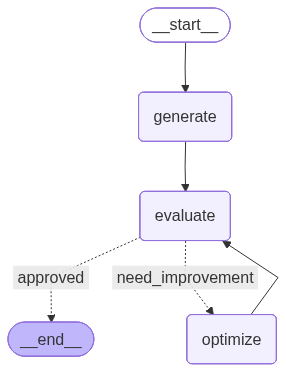

In [44]:
workflow

In [50]:
initial_state = {
    "topic": "AI taking over the world",
    "iteration": 1,
    "max_iterations": 5
    }
final_state = workflow.invoke(initial_state)

In [51]:
from IPython.display import display, Markdown

sections = []
for key, value in final_state.items():
    sections.append(f"### **{key.capitalize()}**\n{value}\n")

output_text = "\n---\n".join(sections)
display(Markdown(output_text))

### **Topic**
AI taking over the world

---
### **Tweet**
"Just had my coffee made by AI and I'm pretty sure it's plotting against me. I mean, who else would put this much foam on a latte and call it 'existential crisis'?" #AITakeover

---
### **Max_iterations**
5

---
### **Iteration**
1

---
### **Feedback**
Solid, original joke with a clever twist on AI coffee. Short, punchy, and hashtaged for virality. No format violations. Great as is.

---
### **Evaluation**
approved

---
### **Tweet_history**
['"Just had my coffee made by AI and I\'m pretty sure it\'s plotting against me. I mean, who else would put this much foam on a latte and call it \'existential crisis\'?" #AITakeover']

---
### **Feedback_history**
['Solid, original joke with a clever twist on AI coffee. Short, punchy, and hashtaged for virality. No format violations. Great as is.']
